### This notebook demostrates a non-linear multiple regression approach that is useful for many daily tasks of reservoir engineers estimating the value of horizontal multifrac'd wells. The example addresses the general estimation of EURs for potential drilling locations where analogous offsets and commonly associated data are available.

In [1]:
# import relevant modules:

import os

import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit, differential_evolution, minimize
from scipy.stats import skew

import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error


# settings:

plt.rcParams['figure.figsize'] = (12,7)
sns.set()

### The first section will address the generating phenomena, which are based on the basic physics of an oil reservoir under primary recovery by depletion / solution-gas drive.

### Populate these distributions for the following parameters:
- spacing, distance between laterals wellbores, perpendicular to wellbore (ft)
- phi, porosity (decimal)
- h, reservoir height (ft)
- Sw, water saturation (decimal)
- RF, recovery factor (decimal)


In [2]:
# the number of synthetic wells to be generated:
n = 30

c:\envs\base\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

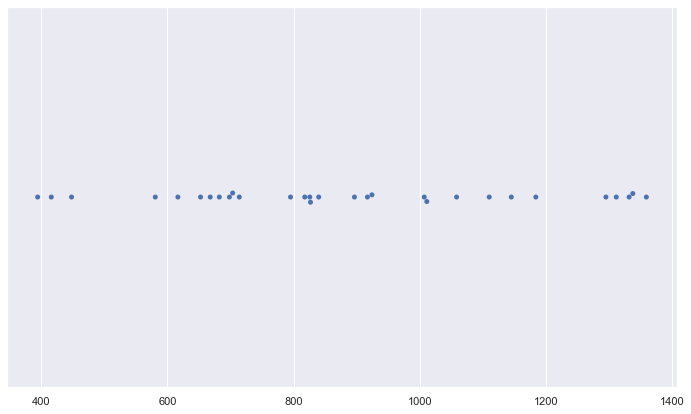

In [3]:
# add n fake wells at various spacings:

spacing = np.random.choice(np.concatenate([np.repeat(440, 6), 
                          np.repeat(660, 8),
                          np.repeat(880, 12), 
                          np.repeat(1056, 10),
                          np.repeat(1320, 8),
                          np.repeat(2640, 1)]), size=n)

# add small random noise to the individual wells spacings:
spacing = spacing * np.random.normal(1, .05, n)

spacing = np.sort(spacing)

sns.swarmplot(spacing)

(0.0, 0.061305615505722)

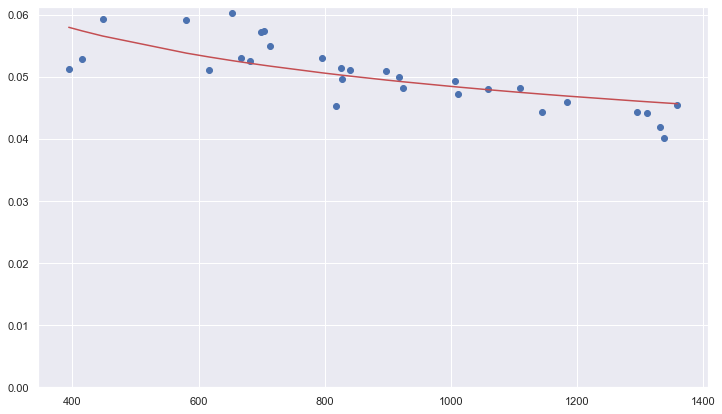

In [4]:
# generate the RF values based on a non-linear decreasing relationship to 
# spacing, based on the assumption that increased well density (decreased
# well spacing) results in higher recovery factors:

RF0 = .1/(spacing**.2 + 0.3) + .1/(spacing**.2) - 0.0
RF_noise = np.random.normal(loc=1, scale=0.05, size=n)
RF = RF0 * RF_noise

plt.plot(spacing, RF0, c='r')
plt.scatter(x=spacing, y=RF)
plt.ylim(0,)

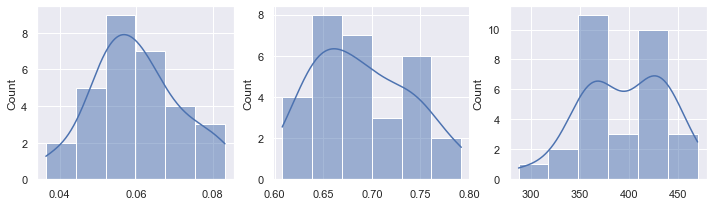

In [5]:
# finally, create the phi, Sw, and h distributions to reflect commonly observed real data:

phi = np.random.normal(loc=.06, scale=.01, size=n).clip(min=0.01)
Sw = np.random.normal(loc=.7, scale=.05, size=n).clip(min=0.4, max=.98)
h = np.random.normal(loc=400, scale=50, size=n).clip(min=0)

ax1 = plt.subplot(231)
ax1 = sns.histplot(phi, kde=True)
ax2 = plt.subplot(232)
ax2 = sns.histplot(Sw, kde=True)
ax3 = plt.subplot(233)
ax3 = sns.histplot(h, kde=True)

In [6]:
# create a dafatframe for ease of viewing and manipulation:

df = pd.DataFrame({'spacing': spacing,
                  'phi': phi,
                  'Sw': Sw,
                  'h': h,
                  'RF': RF})


df.describe().T

,count,mean,std,min,25%,50%,75%,max
spacing,30.0,885.399495,283.261554,394.219505,686.152571,833.103618,1096.913387,1358.860503
phi,30.0,0.060060,0.011494,0.036406,0.052975,0.059224,0.065823,0.083230
Sw,30.0,0.690073,0.049709,0.607869,0.649871,0.685873,0.729975,0.791914
h,30.0,394.900008,43.719607,287.743477,364.112013,403.027650,428.690892,470.245249
RF,30.0,0.050285,0.005199,0.040219,0.046225,0.050464,0.053065,0.060302


In [7]:
# populate fake completions fluid volumes, defaulting to ~45 bbl/ft:
df['compl_bbl_per_ft'] = np.random.choice([45,45,45,45,45,33,31,35,52,55,65,72], size=n)

# add small random noise to the compl. fluid vols:
df['compl_bbl_per_ft'] = df['compl_bbl_per_ft'] + np.random.normal(1, 1, n)

# populate completion sand concentration as a random choice between three concentration rates (lbs 
# sand per bbls compl fluid) options, with a 3/5 preference for 40 lbs/bbl:
df['compl_sd_conc'] = np.random.choice([30, 40, 40, 40, 50], n)

# Add a sand load (lbs compl sand per foot) column. This is for familiar
# viewing only. Generally fluid load (lbs fluid / ft) and sand load (lbs sd per foot)
# will have problematic multicollinearity, so sand load will be omitted in the regression
# in favor of sand concentration.
df['compl_lbs_sd_per_ft'] = df['compl_bbl_per_ft'] * df['compl_sd_conc']

df.head(10)

,spacing,phi,Sw,h,RF,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft
0,394.219505,0.053568,0.666673,438.970325,0.051282,66.694513,50,3334.725631
1,415.871878,0.051297,0.791914,403.682963,0.052968,45.639507,40,1825.580300
2,447.939899,0.055039,0.650185,470.245249,0.059301,31.566089,50,1578.304426
3,580.679255,0.071353,0.607869,429.221871,0.059170,71.349012,40,2853.960474
4,616.478246,0.062893,0.634460,426.555893,0.051129,52.881003,30,1586.430094
5,652.387657,0.074226,0.784951,426.864104,0.060302,44.384142,30,1331.524266
6,667.684345,0.069415,0.731804,402.372337,0.053098,46.235624,30,1387.068733
7,682.149167,0.048420,0.688075,378.400535,0.052629,45.333441,30,1360.003218
8,698.162783,0.051953,0.639558,373.923558,0.057193,53.995376,50,2699.768821
9,703.251665,0.039767,0.649766,359.146724,0.057378,30.633737,30,919.012120


## Define a function for the initial population of fake well EURs, define a related cost function, and set related parameters.
### Utilize a modified sigmoid function, where
<ul>
    <li>L is the horizontal asymptote - the EUR for true stand-alone wells
    <li>k is the exponential factor - typically very small (k << 0.1)
    <li>b0 is the vertical axis intercept - the EUR two wells occupying the same position (zero spacing) would recover

In [8]:
k = 0.0025
L = 120
b0 = 60

# population function
# this is out underlying (synthetic) EUR/ft relationship
def mod_sig(spacing, k, L, b0):
    LL = 2 * (L - b0)
    return LL / (1 + np.exp(-k * (spacing - 0))) - LL/2 + b0

# We expect error in EUR/ft to be lognormally distributed for a given state of
# the determinants we examine. So we define a cost function that allows the curve_fit
# algorithm to measure error against the log of EUR/ft, while still allowing us to 
# choose constraints for the algorithm which fit our intuitive understanding (linear
# space) of the reservoir & the data.

def cost(x, k, L, b0):
    return np.log(mod_sig(x, k, L, b0))


# note that mean absolute error is preferable here for a cost function. This
# is to avoid the initial non-linear fit being too sensitive to outliers created
# by noise / unaccounted-for determinants. I'll define a function to demonstrate:

def mae(params):
    lny = np.log(y)
    lnyhat = np.log(mod_sig(x, params[0], params[1], params[2]))
    return abs(lny - lnyhat).sum()

(0.0, 104.47726304735434)

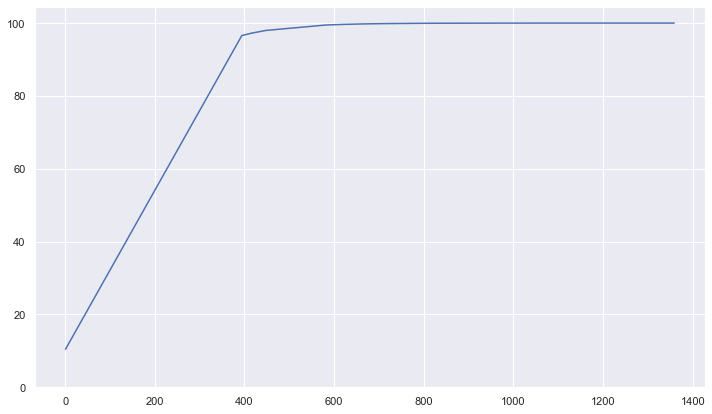

In [9]:
fakeeurs = mod_sig(np.append(1, spacing), .01, 100, 10)

plt.plot(np.append(1,spacing), fakeeurs)
plt.ylim(0,)

### Populate the fake EUR data & add noise

In [10]:
# adjust the RF by 5% for 25% change in sand concentration:
sd_conc_factor = 0.05 / .25

# adjust the RF by 10% for every 25% change in compl fluid per ft:
fluid_pft_factor = 0.1 / .25

# df['eur_per_ft'] = df.apply(lambda x: mod_sig(x['spacing'], k, L, b0), axis=1)
df['RF'] = (1 + ((df['compl_sd_conc'] - 40) / 40) * (sd_conc_factor)) * df['RF']
df['RF'] = (1 + ((df['compl_bbl_per_ft'] - 45) / 45) * (fluid_pft_factor)) * df['RF']

# eur_noise = np.random.lognormal(sigma=np.std(df['eur_per_ft']) / 10, size=len(df))

# df['eur_per_ft'] = df['eur_per_ft'] + eur_noise

df['eurpft'] = 7758 * df['spacing'] * df['phi'] * (1 - df['Sw']) * df['RF'] * df['h'] / (43560 * 1.3)

df = df.sort_values('spacing')

df.sort_values('eurpft')

,spacing,phi,Sw,h,RF,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft,eurpft
1,415.871878,0.051297,0.791914,403.682963,0.053269,45.639507,40,1825.580300,13.077643
9,703.251665,0.039767,0.649766,359.146724,0.047548,30.633737,30,919.012120,22.915018
7,682.149167,0.048420,0.688075,378.400535,0.050146,45.333441,30,1360.003218,26.783215
0,394.219505,0.053568,0.666673,438.970325,0.064230,66.694513,50,3334.725631,27.189876
2,447.939899,0.055039,0.650185,470.245249,0.054831,31.566089,50,1578.304426,30.464342
14,826.589571,0.058903,0.683670,328.152205,0.047460,45.745033,30,1372.350987,32.861655
5,652.387657,0.074226,0.784951,426.864104,0.056973,44.384142,30,1331.524266,34.695850
6,667.684345,0.069415,0.731804,402.372337,0.050997,46.235624,30,1387.068733,34.943229
17,916.812413,0.036406,0.649355,435.672429,0.050440,46.121246,40,1844.849851,35.234936
24,1183.673457,0.046710,0.712307,363.771092,0.046751,53.114732,30,1593.441957,37.060130


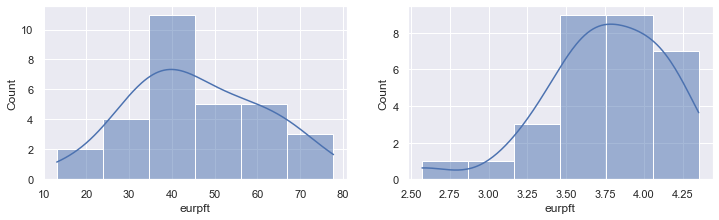

In [11]:
ax1 = plt.subplot(221)
ax1 = sns.histplot(df['eurpft'], kde=True)
ax2 = plt.subplot(222)
ax2 = sns.histplot(np.log(df['eurpft']), kde=True)

(0.0, 1407.0925527078907)

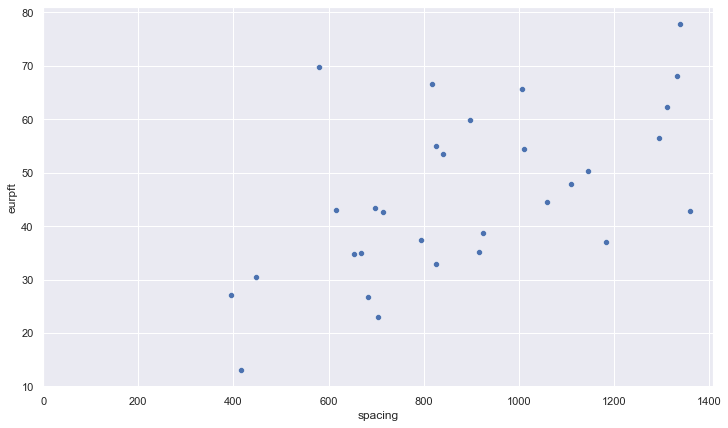

In [12]:
sns.scatterplot(data=df, x='spacing', y='eurpft')
plt.xlim(0, None)

(0.0, 4.443156227831208)

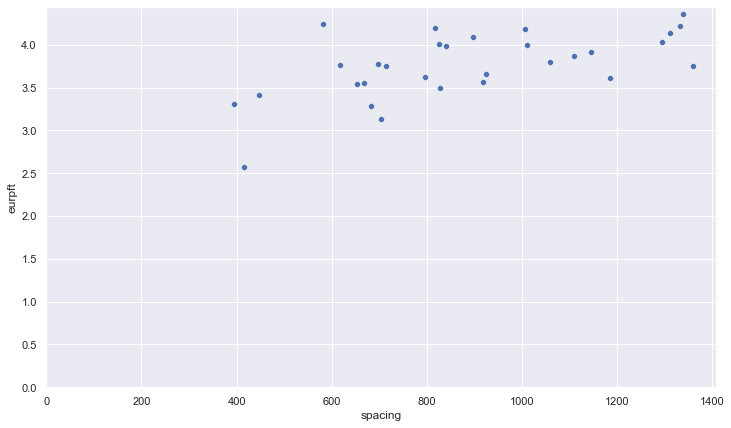

In [13]:
ax1 = sns.scatterplot(data=df, x='spacing', y=np.log(df['eurpft']))
plt.xlim(0, None)
plt.ylim(0, None)

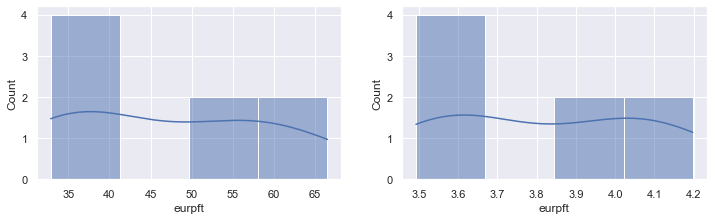

In [14]:
lwr = 770
upr = 968

dfx = df.loc[(df['spacing'] >= lwr) & (df['spacing'] <= upr)]

ax1 = plt.subplot(221)
ax1 = sns.histplot(dfx['eurpft'], kde=True)
ax2 = plt.subplot(222)
ax2 = sns.histplot(np.log(dfx['eurpft']), kde=True)

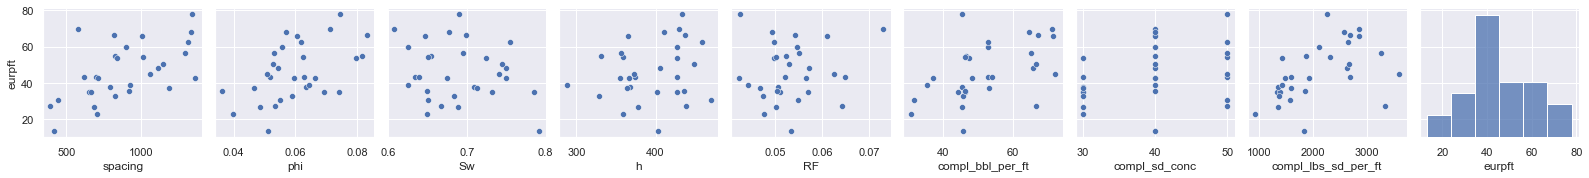

In [15]:
sns.pairplot(df, y_vars='eurpft')

Fit (MSE): k: 0.00177      L: 70.00      b0: 0.00
Fit (MAE): k: 0.00131      L: 77.87      b0: 10.13


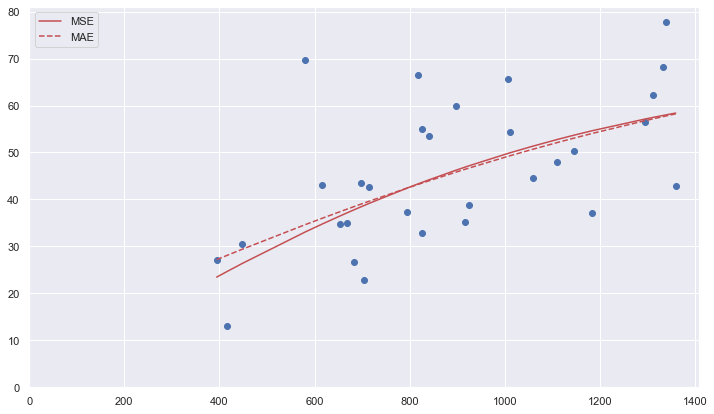

In [16]:
# define x & y space for the initial non-linear fit:
y = df['eurpft']
x = df['spacing'].values

# fit to log-space error using MSE (implicit to scipy curve_fit):
popt, _ = curve_fit(cost, x, np.log(y), bounds=([0, 70, 0], [.1, 200, 100]))


# # use differential evolution to fit log-space error using MAE:
de = differential_evolution(mae, bounds=[(0, .01), (70, 200), (0, 100)])
de_params = (de.x[0], de.x[1], de.x[2])

# # plot the curve fit vs. data
plt.scatter(x=x, y=y)
plt.plot(x, mod_sig(x, *popt), color='r', label='MSE')
plt.plot(x, mod_sig(x, *de_params), c='r', ls='--', label='MAE')
# plt.plot(x, mod_sig(x, k, L, b0), ls='-.', c='black', label='actual')
plt.xlim(0,)
plt.ylim(0,)
plt.legend()


print('Fit (MSE): k: %1.5f      L: %1.2f      b0: %1.2f' % tuple(popt))
print('Fit (MAE): k: %1.5f      L: %1.2f      b0: %1.2f' % tuple(de_params))

<AxesSubplot:xlabel='eurpft', ylabel='Count'>

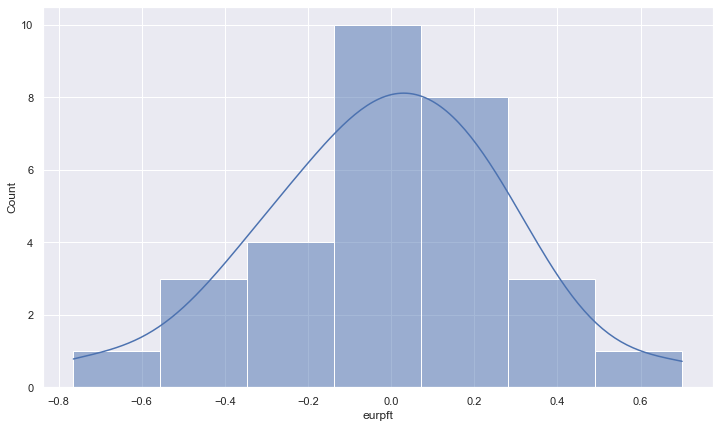

In [17]:
resid = np.log(y) - np.log(mod_sig(x, *de_params))
sns.histplot(resid, kde=True)

In [18]:
# create a df for the remaining determinants,
# to be used in a linear ordinary least squares regression:
dfols = df[['compl_bbl_per_ft', 'compl_sd_conc']]
dfols['log_resid'] = resid
dfols.head(10)

c:\envs\base\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,compl_bbl_per_ft,compl_sd_conc,log_resid
0,66.694513,50,0.000001
1,45.639507,40,-0.764276
2,31.566089,50,0.035746
3,71.349012,40,0.699993
4,52.881003,30,0.178452
5,44.384142,30,-0.073867
6,46.235624,30,-0.081772
7,45.333441,30,-0.361601
8,53.995376,50,0.106868
9,30.633737,30,-0.537302


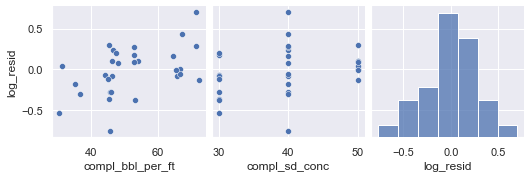

In [19]:
sns.pairplot(dfols, y_vars='log_resid')

In [20]:
Xols = sm.add_constant(dfols.drop('log_resid', axis=1))
yols = dfols['log_resid']

In [21]:
ols = sm.OLS(yols, Xols)
ols_result = ols.fit()

In [22]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_resid   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     4.637
Date:                Thu, 23 Dec 2021   Prob (F-statistic):             0.0186
Time:                        23:14:28   Log-Likelihood:                -1.3674
No. Observations:                  30   AIC:                             8.735
Df Residuals:                      27   BIC:                             12.94
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.8386      0.301     -2.787      0.010      -1.456      -0.221
compl_bbl_per_ft     0.0107      0.004      2.482      0.020       0.002       0.020
compl_sd_conc        0.0067      0.007      0.985      0.333      -0.007       0.021
==============================================================================
Omnibus:                        1.189   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.552   Jarque-Bera (JB):                0.634
Skew:                          -0.355   Prob(JB):                        0.728
Kurtosis:                       3.060   Cond. No.                         411.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
def predict_eur(spacing, fluid_load, sd_conc):
    nonlin = np.log(mod_sig(spacing, *de_params))
    resid = ols_result.predict([1, fluid_load, sd_conc])
    return np.exp(nonlin + resid)[0]

In [24]:
df['model_eur'] = df.apply(lambda x: predict_eur(x['spacing'], x['compl_bbl_per_ft'], x['compl_sd_conc']), axis=1)
df.tail()

,spacing,phi,Sw,h,RF,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft,eurpft,model_eur
25,1294.776285,0.053245,0.695257,357.038352,0.055049,65.344713,50,3267.235657,56.570967,68.933841
26,1311.172354,0.061888,0.754738,458.865241,0.049765,52.978577,50,2648.928853,62.261377,60.787471
27,1331.513242,0.057109,0.676696,411.273139,0.049190,64.700170,40,2588.006806,68.137285,64.998147
28,1337.434899,0.074588,0.690166,433.409422,0.042387,45.417742,50,2270.887095,77.789104,56.643525
29,1358.860503,0.059545,0.749855,366.165397,0.042161,36.935700,40,1477.428004,42.807554,48.791915


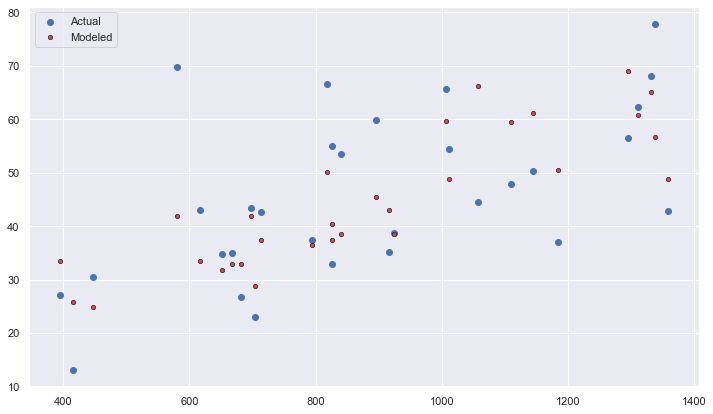

In [25]:
plt.scatter(df['spacing'], df['eurpft'], label='Actual')
plt.scatter(df['spacing'], df['model_eur'], c='r', s=20, edgecolor='black', lw=0.5, label='Modeled')
plt.legend()

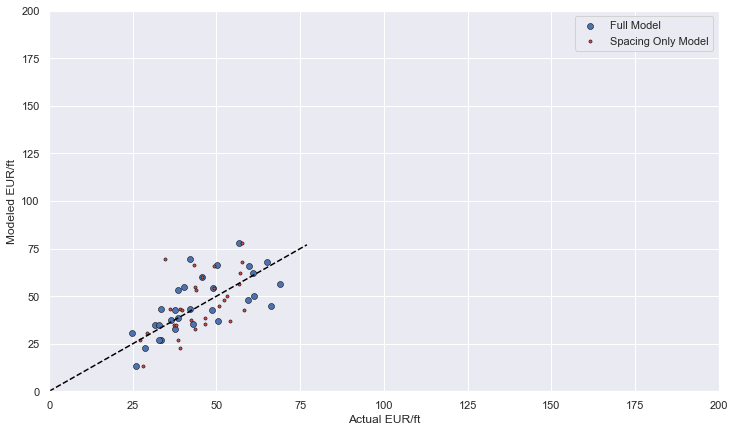

In [26]:
ymod = df['model_eur']
plt.scatter(ymod, y, edgecolor='black', lw=0.5, label='Full Model')

ymod0 = mod_sig(df['spacing'], *de_params)
plt.scatter(ymod0, y, c='r', edgecolor='black', lw=0.5, s=10, label='Spacing Only Model')

plt.xlabel('Actual EUR/ft')
plt.xlim(0,200)

plt.ylabel('Modeled EUR/ft')
plt.ylim(0,200)

line_max = max(ymod.max(), y.max())
linex = np.arange(0, line_max, 1)
liney = linex
plt.plot(linex, liney, c='black', ls='--')

plt.legend()

<AxesSubplot:ylabel='Count'>

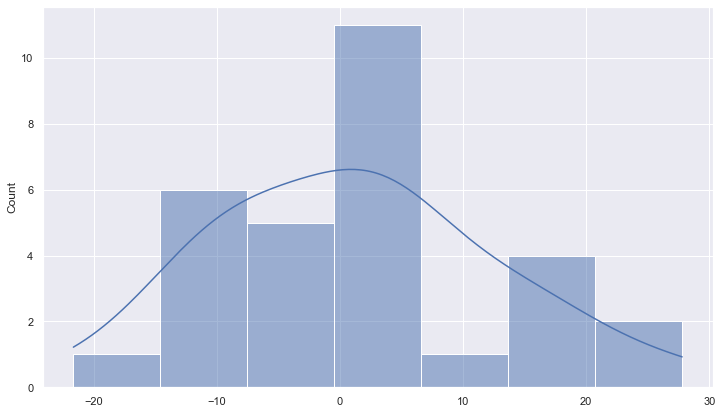

In [27]:
resid = y - ymod

sns.histplot(resid, kde=True)

In [28]:
mean_squared_error(y, ymod0), mean_squared_error(y, ymod)

(155.66288622018018, 127.18085700970255)

In [29]:
mean_absolute_error(y, ymod0), mean_absolute_error(y, ymod)

(9.841352062235114, 9.08380988766709)

---
# Not a bad start.

### More to come...
---